# Integrantes

- Sergio Orellana 221122
- Rodrigo Mansilla 22611
- Carlos Valladares 221164

# Ejercicio 1

## Simulación de tiempo discreto (síncrona) vs. tiempo continuo (asíncrona)

- **Tiempo discreto (síncrona)**: yo actualizo el estado del sistema en pasos fijos (ticks) con un reloj global, de modo que todos los componentes se actualizan “a la vez” en cada paso. Esto es análogo a trabajar con señales muestreadas y diferencia-ecuaciones en control digital. 

- **Tiempo continuo (asíncrona)**: yo permito cambios en cualquier instante real; típicamente lo implemento como simulación dirigida por eventos que “salta” al próximo evento en una cola de eventos, sin pasos fijos. (En marcos como SimPy, los procesos se programan con env.timeout y el motor avanza al siguiente evento).

**(a) ¿Cuándo prefiero cada una?**
Prefiero tiempo discreto (síncrona) cuando:
- El fenómeno ya está muestreado por naturaleza (p. ej., control digital, DSP, comunicaciones digitales). 
- Necesito simplicidad y determinismo (flujo secuencial más fácil de razonar y depurar). 

Prefiero tiempo continuo (asíncrona) cuando:
- El timing exacto de los sucesos importa (colas/redes, tráfico, servicios), porque el motor salta entre eventos sin simular “tiempo vacío”. 
- Busco escala y capacidad de respuesta en sistemas dirigidos por eventos o procesamiento asíncrono. 

**(b) Compensaciones computacionales (velocidad vs. precisión)**
- **Discreto/síncrona:** suele ser más rápida por implementación y más simple de depurar, pero su precisión depende del tamaño del paso (riesgo de aliasing/artefactos si el paso es grande). 
- **Continuo/asíncrona:** logra mejor precisión temporal (eventos en el instante exacto) y puede ser eficiente al evitar pasos donde nada ocurre; a cambio, incrementa la complejidad (concurrencia, manejo de callbacks/eventos, depuración).

## Mecanismos de gestión de eventos
**(a) ¿Cómo gestionan los cambios de estado las colas de eventos?**

Cuando modelo de forma asíncrona, mantengo una cola de eventos con elementos del tipo (tiempo, tipo, datos). El ciclo de simulación hace:

- Extraer el siguiente evento (el de menor marca de tiempo).
- Avanzar el reloj de simulación a ese instante.
- Aplicar las transiciones de estado y programar nuevos eventos (insertarlos en la cola).

Este patrón aparece tanto en frameworks de simulación (p. ej., SimPy con procesos/env.timeout) como en bucles de eventos (JS: el event loop despacha tareas desde la event queue cuando la pila está libre). 

En arquitectura de sistemas, las message queues/colas de mensajes permiten desacoplar productores y consumidores de eventos, reforzando la idea de que los cambios de estado se encolan y se procesan sin bloquear el flujo principal

**(b) Gestión de prioridades para eventos concurrentes**

Para resolver eventos “al mismo tiempo” o con diferentes importancias, utilizo una cola de prioridad (típicamente un binary heap), donde sale primero el evento de mayor prioridad (o menor tiempo y, si hay empates, un criterio secundario). Las operaciones de insertar y extraer tienen costo O(log n), lo que mantiene eficiente el motor de simulación. Además, las simulaciones dirigidas por eventos son un caso de uso clásico de colas de prioridad. 

Como ejemplo de priorización de colas en un bucle de eventos, en JavaScript existen microtareas que se procesan antes de las tareas normales, mostrando cómo la política de prioridad afecta qué se ejecuta primero cuando hay concurrencia.



R_eff (discreto): 2.706
R_eff (eventos):  2.000


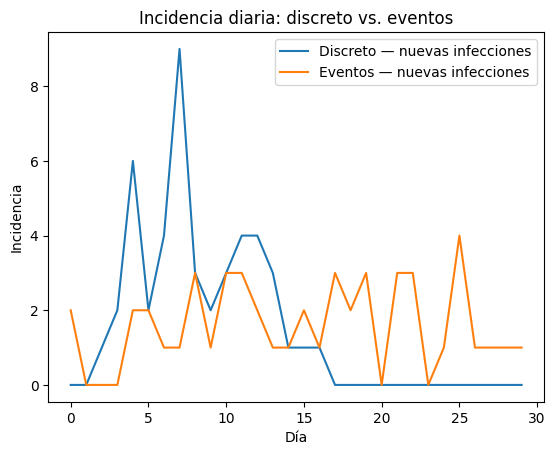

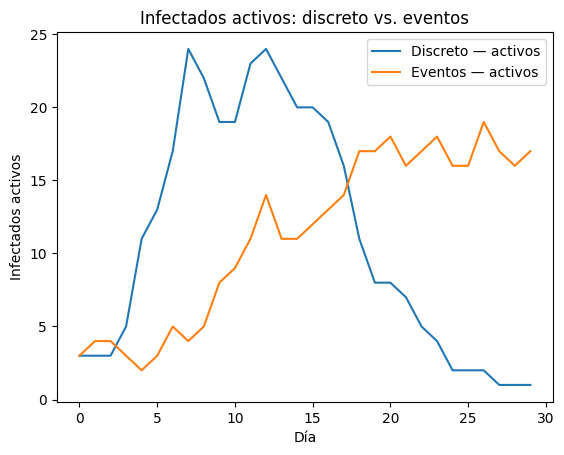

In [4]:
import math
import random
import heapq
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# Utilidades

def poisson_knuth(lam: float) -> int:
    """Muestreo de Poisson con el algoritmo de Knuth (adecuado para lambda pequeña-media)."""
    if lam <= 0:
        return 0
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        p *= random.random()
    return k - 1

def expovariate_safe(rate: float) -> float:
    """Devuelve tiempo de espera exponencial con media 1/rate; maneja rate=0."""
    if rate <= 0:
        return float('inf')
    return random.expovariate(rate)

# Dominio
@dataclass
class Agent:
    id: int
    role: str            # 'patient' o 'staff'
    ward: int            # sala (0,1, ...)
    state: str = 'S'     # 'S','I','R'
    infected_by: Optional[int] = None
    inf_time: Optional[float] = None
    rec_time: Optional[float] = None
    mask: float = 0.6     # [0,1] (1 = máxima adherencia)
    hygiene: float = 0.6  # [0,1]
    immunity: float = 0.0 # [0,1] (1 = completamente inmune)

class Params:
    """
    Parámetros del hospital y de la enfermedad.
    """
    def __init__(self):
        # Estructura
        self.wards = [0, 1]     # dos salas
        self.n_patients = 50
        self.n_staff = 10

        # Enfermedad
        self.beta = 0.06              # prob. base de transmisión por contacto
        self.mask_eff = 0.35          # reducción fraccional por uso de mascarilla (por cada lado)
        self.hygiene_eff = 0.25       # reducción fraccional por higiene promedio
        self.inf_mean_days = 7.0      # duración media infecciosa (días)

        # Contactos esperados por día
        self.c_rate_patient = 6.0
        self.c_rate_staff = 12.0

        # Movimiento entre salas
        self.move_rate_per_day = 0.02

        # Discreto
        self.days = 30

        # Dirigido por eventos
        self.horizon_days = 30.0
        self.max_events = 100_000

def transmission_prob(p: Params, a: Agent, b: Agent) -> float:
    """
    Probabilidad efectiva de transmisión en un contacto a->b.
    Incluye efectos de mascarilla, higiene e inmunidad (susceptibilidad).
    """
    mask_mult = (1 - p.mask_eff * a.mask) * (1 - p.mask_eff * b.mask)
    hygiene_mult = 1 - p.hygiene_eff * (a.hygiene + b.hygiene) / 2.0
    susceptibility_mult = 1 - b.immunity
    pr = p.beta * mask_mult * hygiene_mult * susceptibility_mult
    return max(0.0, min(1.0, pr))

def sample_infectious_duration(p: Params) -> float:
    """Muestra una duración infecciosa ~ Exponencial(media = p.inf_mean_days)."""
    return random.expovariate(1.0 / p.inf_mean_days)

def init_agents(p: Params, rng_seed: Optional[int] = None) -> List[Agent]:
    """
    Inicializa pacientes y personal con heterogeneidad en adherencia e inmunidad.
    Si rng_seed no es None, siembra aleatoriedad para reproducibilidad.
    """
    if rng_seed is not None:
        random.seed(rng_seed)

    agents: List[Agent] = []

    # Pacientes
    for i in range(p.n_patients):
        agents.append(Agent(
            id=i,
            role='patient',
            ward=random.choice(p.wards),
            mask=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
            hygiene=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
            immunity=max(0.0, random.gauss(0.05, 0.05)),
        ))

    # Personal
    for j in range(p.n_staff):
        agents.append(Agent(
            id=p.n_patients + j,
            role='staff',
            ward=random.choice(p.wards),
            mask=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
            hygiene=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
            immunity=max(0.0, random.gauss(0.10, 0.05)),
        ))

    # Semilla de infecciones iniciales
    seed_ids = random.sample(range(len(agents)), k=3)
    for sid in seed_ids:
        a = agents[sid]
        a.state = 'I'
        a.inf_time = 0.0
        a.rec_time = sample_infectious_duration(p)

    return agents

# Arquitectura 1: tiempo discreto

def run_discrete(p: Params, seed: int = 123) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}  # número de secundarios por infectante

    daily_incidence: List[int] = []
    daily_active: List[int] = []

    for day in range(p.days):
        new_inf = 0

        # Recuperaciones al inicio del día
        for a in agents:
            if a.state == 'I' and a.rec_time is not None and a.rec_time <= day:
                a.state = 'R'

        # Índice por sala
        ward_index: Dict[int, List[Agent]] = {w: [] for w in p.wards}
        for a in agents:
            ward_index[a.ward].append(a)

        # Contactos
        for a in agents:
            lam = p.c_rate_patient if a.role == 'patient' else p.c_rate_staff
            k = poisson_knuth(lam)
            if k <= 0:
                continue

            peers = ward_index[a.ward]
            if len(peers) <= 1:
                continue

            for _ in range(k):
                b = random.choice(peers)
                if b.id == a.id:
                    continue

                # Intentar transmisión en ambos sentidos
                if a.state == 'I' and b.state == 'S':
                    pr = transmission_prob(p, a, b)
                    if random.random() < pr:
                        b.state = 'I'
                        b.inf_time = float(day)
                        b.rec_time = day + sample_infectious_duration(p)
                        b.infected_by = a.id
                        offspring[a.id] += 1
                        new_inf += 1

                elif b.state == 'I' and a.state == 'S':
                    pr = transmission_prob(p, b, a)
                    if random.random() < pr:
                        a.state = 'I'
                        a.inf_time = float(day)
                        a.rec_time = day + sample_infectious_duration(p)
                        a.infected_by = b.id
                        offspring[b.id] += 1
                        new_inf += 1

        # Movimiento
        for a in agents:
            if random.random() < p.move_rate_per_day:
                a.ward = 1 - a.ward

        # Métricas
        active = sum(1 for a in agents if a.state == 'I')
        daily_incidence.append(new_inf)
        daily_active.append(active)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for x in offspring.values() if x > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame({
        "day": list(range(p.days)),
        "new_infections": daily_incidence,
        "active_infected": daily_active
    })
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring

# Arquitectura 2: dirigida por eventos
def run_event_driven(p: Params, seed: int = 456) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}

    # Cola de eventos: (time, seq, type, agent_id, payload)
    q: List[Tuple[float, int, str, int, dict]] = []
    seq = 0

    def schedule(time: float, typ: str, aid: int, payload: dict = None):
        nonlocal seq
        heapq.heappush(q, (time, seq, typ, aid, payload or {}))
        seq += 1

    def contact_rate(a: Agent) -> float:
        return p.c_rate_patient if a.role == 'patient' else p.c_rate_staff

    # Inicialización: primer contacto y movimiento de cada agente; recuperaciones para infectados
    for a in agents:
        schedule(expovariate_safe(contact_rate(a)), "contact", a.id)
        schedule(expovariate_safe(p.move_rate_per_day), "move", a.id)
        if a.state == 'I':
            schedule(sample_infectious_duration(p), "recovery", a.id)

    infection_times: List[float] = []
    recovery_times: List[float] = []

    events_processed = 0
    while q and events_processed < p.max_events:
        t, _, typ, aid, payload = heapq.heappop(q)
        if t > p.horizon_days:
            break
        a = agents[aid]

        if typ == "contact":
            # Reprogramar siguiente contacto de este agente
            schedule(t + expovariate_safe(contact_rate(a)), "contact", a.id)

            # Elegir contraparte en la misma sala
            peers = [x for x in agents if x.ward == a.ward and x.id != a.id]
            if peers:
                b = random.choice(peers)

                # Intentar transmisión en ambos sentidos
                def try_transmit(src: Agent, dst: Agent):
                    nonlocal infection_times
                    if src.state == 'I' and dst.state == 'S':
                        pr = transmission_prob(p, src, dst)
                        if random.random() < pr:
                            dst.state = 'I'
                            dst.inf_time = t
                            dur = sample_infectious_duration(p)
                            dst.rec_time = t + dur
                            dst.infected_by = src.id
                            offspring[src.id] += 1
                            infection_times.append(t)
                            # Programar recuperación del nuevo infectado
                            schedule(dst.rec_time, "recovery", dst.id)

                try_transmit(a, b)
                try_transmit(b, a)

        elif typ == "recovery":
            if a.state == 'I':
                a.state = 'R'
                a.rec_time = t
                recovery_times.append(t)

        elif typ == "move":
            # Cambio de sala y reprogramación del próximo movimiento
            a.ward = 1 - a.ward
            schedule(t + expovariate_safe(p.move_rate_per_day), "move", a.id)

        events_processed += 1

    # Agregación diaria de métricas 
    days = int(math.ceil(p.horizon_days))
    daily_incidence: List[int] = [0] * days
    for it in infection_times:
        d = int(math.floor(it))
        if 0 <= d < days:
            daily_incidence[d] += 1

    daily_active: List[int] = []
    for d in range(days):
        cnt = 0
        for ag in agents:
            if ag.inf_time is not None and ag.inf_time <= d:
                # Si rec_time es None o mayor al día actual, sigue activo
                if ag.rec_time is None or d < ag.rec_time:
                    cnt += 1
        daily_active.append(cnt)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for v in offspring.values() if v > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame({
        "day": list(range(days)),
        "new_infections": daily_incidence,
        "active_infected": daily_active
    })
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring

if __name__ == "__main__":
    random.seed(42)

    p = Params()
    df_disc, off_disc = run_discrete(p, seed=101)
    df_ev, off_ev = run_event_driven(p, seed=202)

    print(f"R_eff (discreto): {df_disc.attrs.get('R_eff_estimate'):.3f}")
    print(f"R_eff (eventos):  {df_ev.attrs.get('R_eff_estimate'):.3f}")

    # Incidencia diaria
    plt.figure()
    plt.plot(df_disc["day"], df_disc["new_infections"], label="Discreto — nuevas infecciones")
    plt.plot(df_ev["day"], df_ev["new_infections"], label="Eventos — nuevas infecciones")
    plt.xlabel("Día")
    plt.ylabel("Incidencia")
    plt.title("Incidencia diaria: discreto vs. eventos")
    plt.legend()
    plt.show()

    # Activos diarios
    plt.figure()
    plt.plot(df_disc["day"], df_disc["active_infected"], label="Discreto — activos")
    plt.plot(df_ev["day"], df_ev["active_infected"], label="Eventos — activos")
    plt.xlabel("Día")
    plt.ylabel("Infectados activos")
    plt.title("Infectados activos: discreto vs. eventos")
    plt.legend()
    plt.show()


## Especificación (discreto)

**Reloj:** `d = 0, 1, 2, ...` (días)

**Ciclo por día:**
1. Procesar recuperaciones (`rec_time <= d`).
2. Construir índice de sala → lista de agentes.
3. Para cada agente, muestrear `#contactos ~ Poisson(c_rate_role)`.
   - Para cada contacto, elegir un par aleatorio en la misma sala y evaluar transmisión en ambos sentidos.
4. Aplicar movimiento (con probabilidad pequeña por día).
5. Medir métricas: nuevas infecciones del día e infectados activos.

**Eventos a monitorizar (implícitos por paso):**
- Contacto (potencial contagio)
- Recuperación
- Movimiento

**Métricas de salida:**
- Incidencia diaria
- Activos diarios
- R_eff (crudo)
- Descendencia por agente (número de secundarios por infectante)

## Especificación (dirigida por eventos)

**Reloj:** tiempo continuo; el simulador **salta** al tiempo del **siguiente evento**.

**Estructura de eventos:** cola de prioridad (*heap*) con tuplas  
`(time, seq, type, agent_id, payload)`.

**Tipos de eventos:**
- `contact`: un agente tiene contacto; se elige una contraparte en la misma sala y se intenta transmisión en ambos sentidos.  
  Se programa el próximo contacto del agente con espera `~ Expon(rate_contacto)`.
- `recovery`: un infectado pasa a `R`.
- `move`: cambio de sala; se reprograma el próximo movimiento `~ Expon(move_rate)`.

**Métricas de salida:**
- A partir de las marcas temporales de infecciones:
  - Incidencia diaria agregada
  - Activos diarios (conteo entre `inf_time` y `rec_time`)
  - R_eff
  - Descendencia por agente


# Referencias

- GeeksforGeeks. (2024, February 27). Continuous time and discrete time control systems. GeeksforGeeks. https://www.geeksforgeeks.org/electrical-engineering/continuous-time-and-discrete-time-control-systems/
- GeeksforGeeks. (2024b, May 31). Synchronous and asynchronous programming. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/synchronous-and-asynchronous-programming/
- GeeksforGeeks. (2020, November 19). Basics of Discrete Event Simulation using SimPy. GeeksforGeeks. https://www.geeksforgeeks.org/python/basics-of-discrete-event-simulation-using-simpy/
- GeeksforGeeks. (2025, July 23). EventDriven Architecture System design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/event-driven-architecture-system-design
- GeeksforGeeks. (2025a, July 23). Asynchronous processing in system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/asynchronous-processing-in-system-design/
- GeeksforGeeks. (2025c, August 5). Event queue in JavaScript. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/event-queue-in-javascript
- GeeksforGeeks. (2025d, August 7). Message queues system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/message-queues-system-design
- GeeksforGeeks. (2025c, July 23). What is Priority Queue | Introduction to Priority Queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/priority-queue-set-1-introduction/
- GeeksforGeeks. (2025a, July 23). Applications of priority queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/applications-priority-queue/
- GeeksforGeeks. (2023, January 25). What are the microtask and macrotask within an event loop in JavaScript ? GeeksforGeeks. https://www.geeksforgeeks.org/javascript/what-are-the-microtask-and-macrotask-within-an-event-loop-in-javascript/